Сверху код и примеры как финальная работа

Сразу после примеров работы - разбор с пошаговым выводом (аналог ячейка - функция)

Пока что здесь принимается, что арка стоит ровно, а блокнот можно двигать только параллельным переносом

# Код в целом и еще несколько примеров

In [92]:
import matplotlib.pyplot as plt
import numpy as np
from imageio import imread, imsave
from skimage.color import rgb2gray
import cv2 as cv
from skimage.filters import gaussian
from skimage.morphology import binary_opening
from skimage.measure import label, regionprops
from skimage.filters import threshold_minimum
from matplotlib.patches import Rectangle


def get_largest_component(mask, comp_num=1):
    labels = label(mask) # разбиение маски на компоненты связности
    props = regionprops(labels) # нахождение свойств каждой области (положение центра, площадь, bbox, интервал интенсивностей и т.д.)
    areas = [prop.area for prop in props] # нас интересуют площади компонент связности

    largest_comp_id = np.array(areas).argmax() # находим номер компоненты с максимальной площадью
    
    if comp_num == 2:
        areas[largest_comp_id] = 0
        largest_comp_id = np.array(areas).argmax()
        
    return labels == (largest_comp_id + 1) # области нумеруются с 1, поэтому надо прибавить 1 к индексу


def get_binary_objects(img, sigma=2.5):
    img_blur = gaussian(img, sigma=sigma, multichannel=True)

    img_blur_gray = rgb2gray(img_blur)
    
    # minimum оказался самым симпатичным, поэтому он везде
    thresh_min = threshold_minimum(img_blur_gray)
    
    # отсекаем, что не нужно
    res_min = img_blur_gray <= thresh_min
    
    # немножко прасив открытием (закрытие мало что изменило)
    res_min_enclosed = binary_opening(res_min, selem=np.ones((15, 15)))
    
    # площадь блокнота больше, чем арки - пользуемся и находим
    # в моей постановке нет мастабирования
    notepad_img = get_largest_component(res_min_enclosed, 1)
    arch_img = get_largest_component(res_min_enclosed, 2)
    
    # возвращаем маски
    return notepad_img, arch_img


def get_notepad_borders(mask):
    
    # индексы строк, в которых есть хотя бы 1 белый пиксель
    vertical_indices = np.where(np.any(mask, axis=1))[0]
    top, bottom = vertical_indices[0], vertical_indices[-1]

    # идексы столбцов, в которых есть хотя бы 1 белый пиксель
    horizontal_indices = np.where(np.any(mask, axis=0))[0]
    left, right = horizontal_indices[0], horizontal_indices[-1]
    
    return top, bottom, left, right


def get_arch_inner_borders(mask, shift=40, threshold=0.3):
    
    # индексы строк, в которых есть хотя бы 1 белый пиксель
    vertical_indices = np.where(np.any(mask, axis=1))[0]
    top, bottom = vertical_indices[0], vertical_indices[-1]
    
    # идексы столбцов, в которых есть хотя бы 1 белый пиксель
    horizontal_indices = np.where(np.any(mask, axis=0))[0]
    left, right = horizontal_indices[0], horizontal_indices[-1]
    
    # теперь работаем внутри внешних границ арки
    min_mask = mask[top+shift:bottom-shift, left+shift:right-shift]

    # строки, в которых число белых пикселей менее 30% (порог необходим, так как не факт, 
    # что до конца перекроются все дырки в арке)
    vertical_indices = np.where(np.sum(min_mask, axis=1) / min_mask.shape[1] < threshold)[0]
    inner_top, inner_bottom =  vertical_indices[0] + top + shift, vertical_indices[-1] + top + shift

    # аналогично, но для столбцов
    horizontal_indices = np.where(np.sum(min_mask, axis=0) / min_mask.shape[0] < threshold)[0]
    inner_left, inner_right = horizontal_indices[0] + left +shift, horizontal_indices[-1] + left + shift
    
    return inner_top, inner_bottom, inner_left, inner_right


def is_fit(notepad_borders, arch_borders):
    inner_top, inner_bottom, inner_left, inner_right = arch_borders
    top_notepad, bottom_notepad, left_notepad, right_notepad = notepad_borders
    
    width_arch = inner_right - inner_left
    height_arch = bottom - inner_top

    width_notepad = right_notepad - left_notepad
    height_notepad = bottom_notepad - top_notepad
    
    # по условию арка стоит ровно, 
    # поэтому для параллельного переноса можем узнать ответ вот так просто:
    
    if width_arch > width_notepad and height_arch > height_notepad:
        return 'will fit'
    else:
        return 'no...'

    
def classificator(img_path):
    img = cv.imread(img_path)

    # бинаризация и получение отдельно масок каждого объекта
    notepad_img, arch_img = get_binary_objects(img)

    # получение границ прямоугольников, содержащих объекты
    notepad_borders = get_notepad_borders(notepad_img)
    arch_borders = get_arch_inner_borders(arch_img)
    
    res = img, arch_img, notepad_img, arch_borders, notepad_borders
    
    # проверка влезет ли блокнот в арку и возвращаем данные для графиков
    return is_fit(notepad_borders, arch_borders), res

### Построить промежуточные графики

In [93]:
def plot_mid_results(res):
    
    img, arch, notepad, arch_borders, notepad_borders = res
    
    f, ax = plt.subplots(1, 4, figsize=(50,100))
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    ax[0].imshow(img)
    ax[0].set_title('Исходное изображение', fontsize=36)
    
    ax[1].imshow(arch, cmap='gray')
    ax[2].imshow(notepad, cmap='gray')
    
    ax[1].set_title('Результат бинаризации - арка', fontsize=36)
    ax[2].set_title('Результат бинаризации - блокнот', fontsize=36)
    
    ax[3].imshow(img)
    
    inner_top, inner_bottom, inner_left, inner_right = arch_borders
    corner = (inner_left, inner_top)
    height = inner_bottom - inner_top
    width = inner_right - inner_left
    ax[3].add_patch(Rectangle(corner, width, height, linewidth=5, edgecolor='r', facecolor='none'))
    
    top_notepad, bottom_notepad, left_notepad, right_notepad = notepad_borders
    corner = (left_notepad, top_notepad)
    height = bottom_notepad - top_notepad
    width = right_notepad - left_notepad
    ax[3].add_patch(Rectangle(corner, width, height, linewidth=5, edgecolor='r', facecolor='none'))
    
    ax[3].set_title('Выделенные объекты', fontsize=36)

## Запускаемся и смотрим

will fit


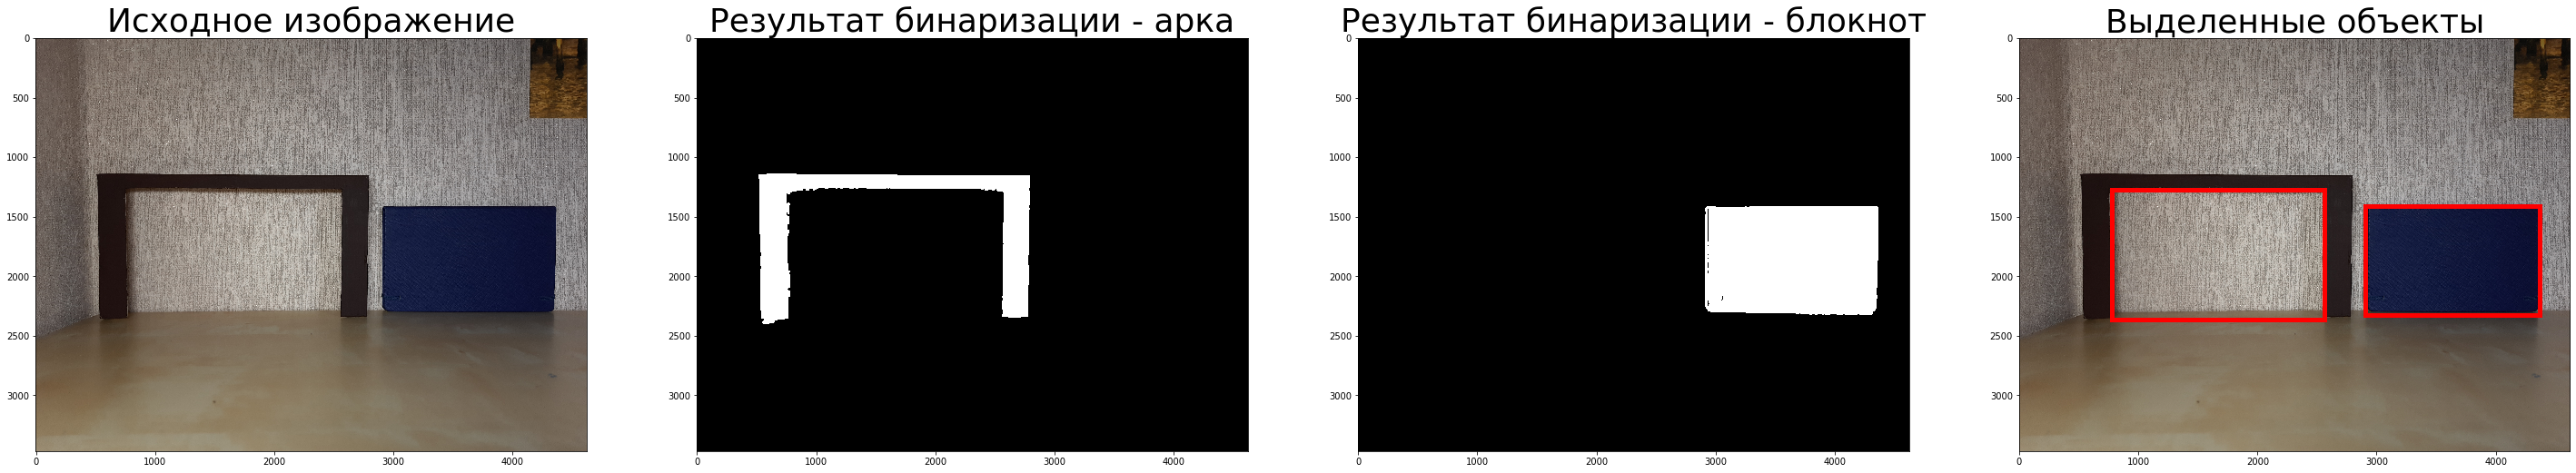

In [94]:
path = 'data/class_1/20210209_190556.jpg'

will_fit, res = classificator(path)
print(will_fit)

plot_mid_results(res)

will fit


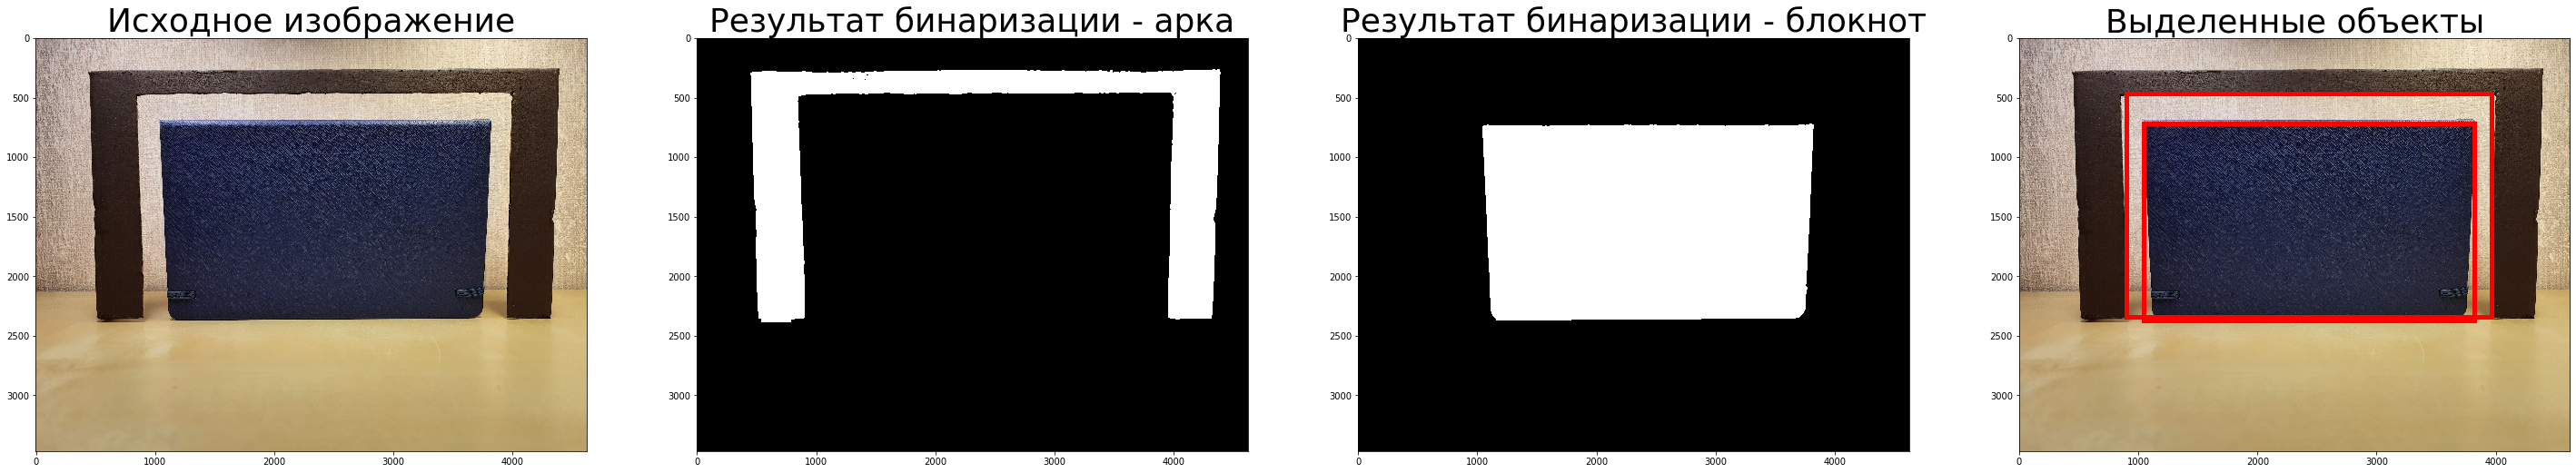

In [95]:
path = 'data/class_1/20210209_180129.jpg'

will_fit, res = classificator(path)
print(will_fit)

plot_mid_results(res)

no...


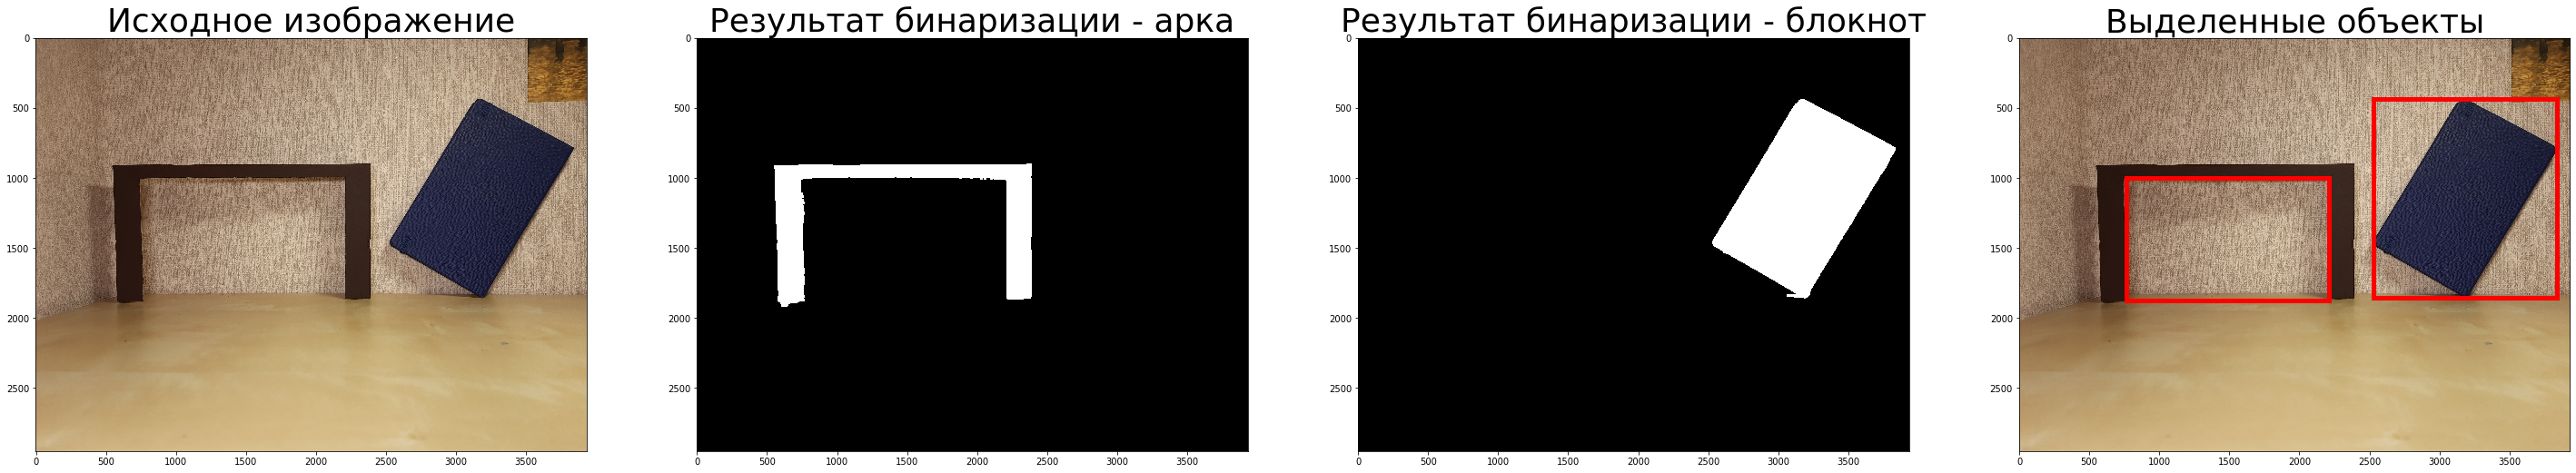

In [96]:
path = 'data/class_0/20210209_223517.jpg'

will_fit, res = classificator(path)
print(will_fit)

plot_mid_results(res)

no...


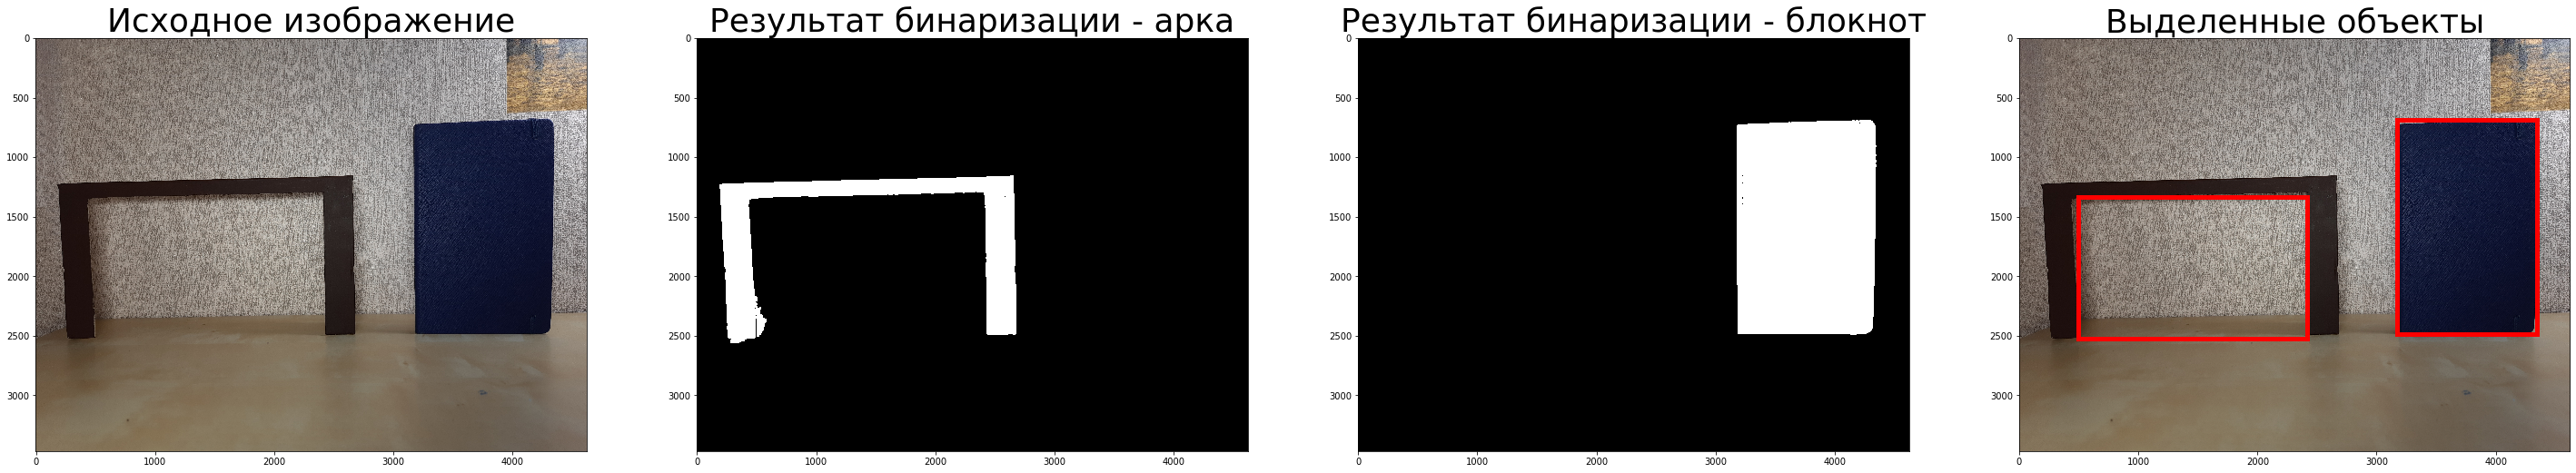

In [97]:
path = 'data/class_0/20210209_191107.jpg'

will_fit, res = classificator(path)
print(will_fit)

plot_mid_results(res)

# Собственно сам рабочий процесс

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from imageio import imread, imsave
from skimage.color import rgb2gray
import cv2 as cv
import cv2
from skimage.filters import try_all_threshold
from skimage.filters import gaussian
from skimage.morphology import binary_opening
from skimage.measure import label, regionprops
from skimage.filters import threshold_minimum

Будем пользоваться бинаризацией + выделением больших компонент связности

In [15]:
def get_largest_component(mask, comp_num=1):
    labels = label(mask) # разбиение маски на компоненты связности
    props = regionprops(labels) # нахождение свойств каждой области (положение центра, площадь, bbox, интервал интенсивностей и т.д.)
    areas = [prop.area for prop in props] # нас интересуют площади компонент связности

    print("Значения площади для каждой компоненты связности: {}".format(areas))
    largest_comp_id = np.array(areas).argmax() # находим номер компоненты с максимальной площадью
    
    if comp_num == 2:
        areas[largest_comp_id] = 0
        largest_comp_id = np.array(areas).argmax()
        
    print("labels - матрица, заполненная индексами компонент связности со значениями из множества: {}".format(np.unique(labels)))
    return labels == (largest_comp_id + 1) # области нумеруются с 1, поэтому надо прибавить 1 к индексу

## Бинаризуем входное изображение

(-0.5, 4623.5, 3467.5, -0.5)

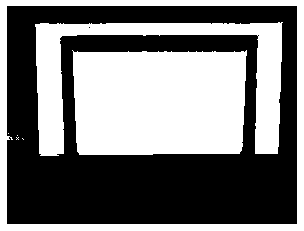

In [29]:
from skimage.filters import threshold_minimum

first_image = cv.imread('data/class_1/20210209_180129.jpg')
img_blur = gaussian(first_image, sigma=2.5, multichannel=True)

img_blur_gray = rgb2gray(img_blur)
thresh_min = threshold_minimum(img_blur_gray)

res_min = img_blur_gray <= thresh_min

plt.imshow(res_min, cmap='gray')
plt.axis('off')

(-0.5, 4623.5, 3467.5, -0.5)

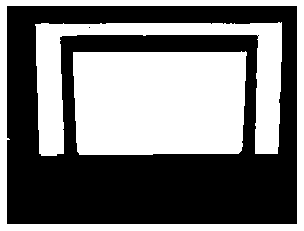

In [30]:
from skimage.morphology import binary_opening, binary_closing

res_min_enclosed = binary_opening(res_min, selem=np.ones((15, 15)))

plt.imshow(res_min_enclosed, cmap='gray')
plt.axis('off')

## Со знанием того, что площадь блокнота больше площади арки выделим их как две компоненты связности

Значения площади для каждой компоненты связности: [2225730, 4412686, 234, 556]
labels - матрица, заполненная индексами компонент связности со значениями из множества: [0 1 2 3 4]


(-0.5, 4623.5, 3467.5, -0.5)

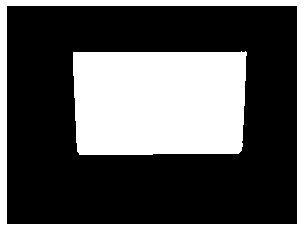

In [31]:
notepad_img = get_largest_component(res_min_enclosed, 1)
plt.imshow(notepad_img, cmap='gray')
plt.axis('off')

Значения площади для каждой компоненты связности: [2225730, 4412686, 234, 556]
labels - матрица, заполненная индексами компонент связности со значениями из множества: [0 1 2 3 4]


(-0.5, 4623.5, 3467.5, -0.5)

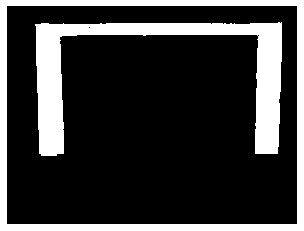

In [32]:
arch_img = get_largest_component(res_min_enclosed, 2)

plt.imshow(arch_img, cmap='gray')
plt.axis('off')

## Получаем границы прямоугольника описывающего блокнот

In [33]:
mask = notepad_img

vertical_indices = np.where(np.any(mask, axis=1))[0]
top_notepad, bottom_notepad = vertical_indices[0], vertical_indices[-1]

horizontal_indices = np.where(np.any(mask, axis=0))[0]
left_notepad, right_notepad = horizontal_indices[0], horizontal_indices[-1]

print(f"Top: {top_notepad}, bottom: {bottom_notepad}")
print(f"Left: {left_notepad}, right: {right_notepad}")

Top: 720, bottom: 2370
Left: 1046, right: 3821


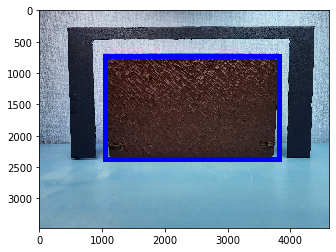

In [34]:
from matplotlib.patches import Rectangle

f, ax = plt.subplots(1, 1)
ax.imshow(first_image)

corner = (left_notepad, top_notepad)
height = bottom_notepad - top_notepad
width = right_notepad - left_notepad
ax.add_patch(Rectangle(corner, width, height, linewidth=5, edgecolor='b', facecolor='none'))

### Получаем границы внешних границ арки

In [35]:
mask = arch_img

vertical_indices = np.where(np.any(mask, axis=1))[0]
top, bottom = vertical_indices[0], vertical_indices[-1]

horizontal_indices = np.where(np.any(mask, axis=0))[0]
left, right = horizontal_indices[0], horizontal_indices[-1]

print(f"Top: {top}, bottom: {bottom}")
print(f"Left: {left}, right: {right}")

Top: 258, bottom: 2385
Left: 447, right: 4391


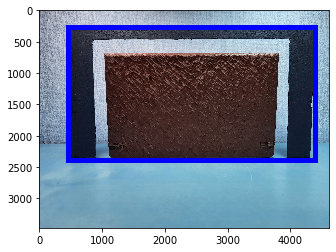

In [36]:
f, ax = plt.subplots(1, 1)
ax.imshow(first_image)

corner = (left, top)
height = bottom - top
width = right - left
ax.add_patch(Rectangle(corner, width, height, linewidth=5, edgecolor='b', facecolor='none'))

### Получаем границы внутренних границ арки

Несмотря на постановку идеальной ровности добиться нельзя. а так как я использую условие, что больше 70% пикселей являются черными (в бинаризованной картинке), то необходим небольшой сдвиг от краев (ниже пример, где по краям есть черные области, а нам нужна серединка)

In [37]:
shift = 40  # сам сдвиг
min_mask = mask[top+shift:bottom-shift, left+shift:right-shift]  # работаем внутри внешних границ арки

# строки, в которых число белых пикселей менее 30% (порог необходим, так как не факт, что до конца перекроются все дырки в арке)
vertical_indices = np.where(np.sum(min_mask, axis=1) / min_mask.shape[1] < 0.3)[0]
inner_top, inner_bottom =  vertical_indices[0] + top + shift, vertical_indices[-1] + top + shift

# аналогично, но для столбцов
horizontal_indices = np.where(np.sum(min_mask, axis=0) / min_mask.shape[0] < 0.3)[0]
inner_left, inner_right = horizontal_indices[0] + left +shift, horizontal_indices[-1] + left + shift


print(f"Inner top: {inner_top}, inner bottom: {bottom}")
print(f"Inner left: {inner_left}, inner right: {inner_right}")

Inner top: 469, inner bottom: 2385
Inner left: 902, inner right: 3962


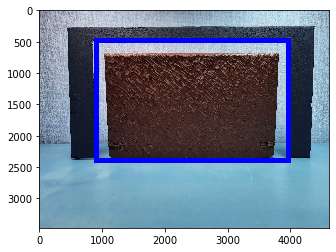

In [38]:
f, ax = plt.subplots(1, 1)
ax.imshow(first_image)

corner = (inner_left, inner_top)
height = bottom - inner_top
width = inner_right - inner_left
ax.add_patch(Rectangle(corner, width, height, linewidth=5, edgecolor='b', facecolor='none'))

### Пример кривизны и того, что маска для арки может выйти не очень

Без сдвига - по краям остались черные полосы, это еще более-менее хороший пример, но есть менее удачные в этом плане

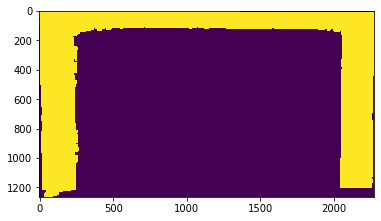

In [24]:
plt.imshow(mask[top:bottom, left:right])

Со сдвигом

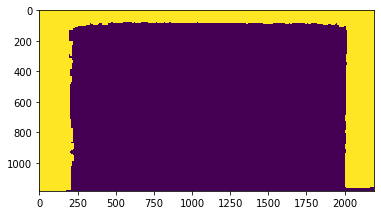

In [25]:
plt.imshow(mask[top+40:bottom-40, left+40:right-40])

### Осталось просто посчитать влезет ли блокнот в арку

In [39]:
width_arch = inner_right - inner_left
height_arch = bottom - inner_top

width_notepad = right_notepad - left_notepad
height_notepad = bottom_notepad - top_notepad

if width_arch > width_notepad and height_arch > height_notepad:
    print('will fit')
else:
    print('no...')


will fit
